In [1]:
from google.colab import drive
drive.mount('/gdrive/')
%cd /gdrive

Mounted at /gdrive/
/gdrive


In [2]:
ls

MyDrive/  Shareddrives/


In [3]:
cd/gdrive/MyDrive/Disease Detection/

/gdrive/MyDrive/Disease Detection


In [4]:
ls

COVID/                malignant_breast_cancer/  pituitary_brain_tumor/
Disease_Detection.h5  Oral_cancer/              Pneumonia/


In [5]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.preprocessing.image import load_img

In [6]:
import os
import PIL
import pathlib
import pandas as pd
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import preprocessing
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.python.ops.numpy_ops import np_utils

In [7]:
BATCH_SIZE = 62
IMAGE_SIZE = 256
EPOCHS=20
CHANNELS=3

In [8]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/gdrive/MyDrive/Disease Detection",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 1972 files belonging to 5 classes.


In [9]:
class_names = dataset.class_names
class_names

['COVID',
 'Oral_cancer',
 'Pneumonia',
 'malignant_breast_cancer',
 'pituitary_brain_tumor']

In [10]:
len(dataset)

32

In [11]:
for image_batch, label_batch in dataset.take(1):
  print(image_batch.shape)
  print(image_batch[1])
  print(label_batch.numpy())

(62, 256, 256, 3)
tf.Tensor(
[[[15.206543  15.206543  15.206543 ]
  [12.364746  12.364746  12.364746 ]
  [12.495117  12.495117  12.495117 ]
  ...
  [13.570801  13.570801  13.570801 ]
  [ 9.955566   9.955566   9.955566 ]
  [13.47998   13.47998   13.47998  ]]

 [[ 8.8515625  8.8515625  8.8515625]
  [10.41748   10.41748   10.41748  ]
  [ 9.822266   9.822266   9.822266 ]
  ...
  [ 9.328613   9.328613   9.328613 ]
  [ 8.810059   8.810059   8.810059 ]
  [ 5.375      5.375      5.375    ]]

 [[10.23584   10.23584   10.23584  ]
  [ 8.9453125  8.9453125  8.9453125]
  [ 7.1757812  7.1757812  7.1757812]
  ...
  [10.625     10.625     10.625    ]
  [ 9.300781   9.300781   9.300781 ]
  [ 8.143555   8.143555   8.143555 ]]

 ...

 [[17.122559  17.122559  17.122559 ]
  [12.448242  12.448242  12.448242 ]
  [13.932129  13.932129  13.932129 ]
  ...
  [21.234375  21.234375  21.234375 ]
  [17.785156  17.785156  17.785156 ]
  [17.        17.        17.       ]]

 [[18.074707  18.074707  18.074707 ]
  [13.83

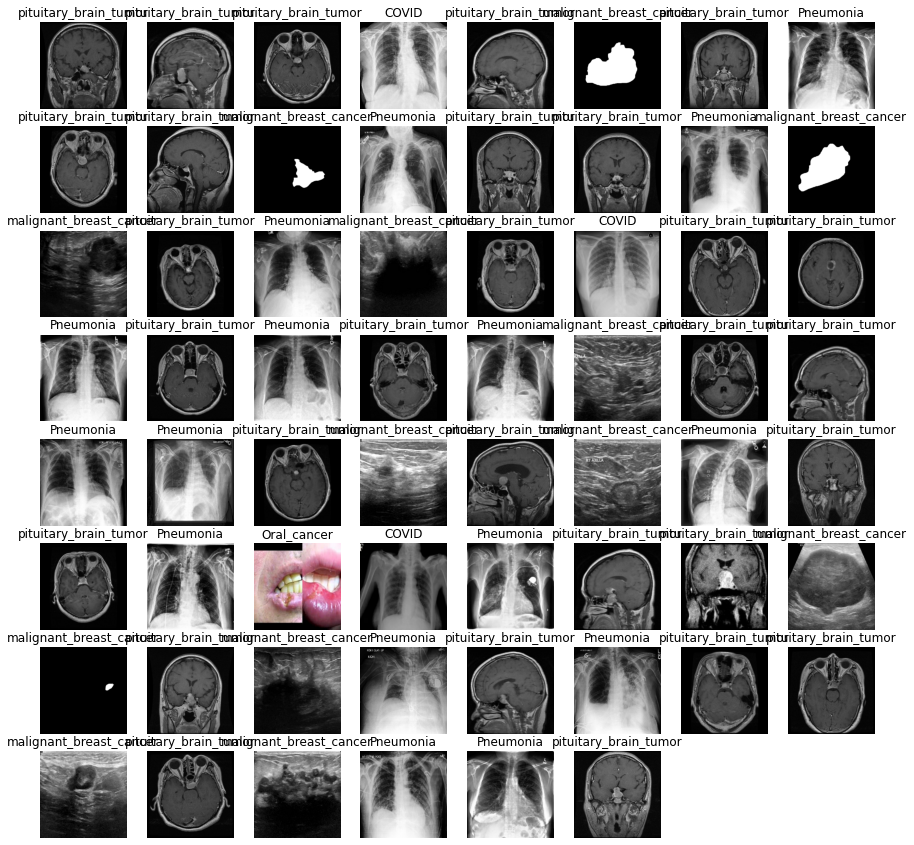

In [12]:
plt.figure(figsize=(15, 15))
for image_batch, labels_batch in dataset.take(1):
    for i in range(BATCH_SIZE):
        ax = plt.subplot(8, 8, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [13]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    # Autotune all the 3 datasets 
    train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
    val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
    test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
    return train_ds, val_ds, test_ds

In [14]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [15]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [16]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [17]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 9

model = models.Sequential([
    resize_and_rescale,
    # data_augmentation,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])
model.build(input_shape=input_shape)

In [18]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [19]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (62, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (62, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (62, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (62, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (62, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (62, 60, 60, 64)         

In [20]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
)

Epoch 1/20
25/25 [==============================] - 371s 7s/step - loss: 1.2260 - accuracy: 0.6219 - val_loss: 0.4255 - val_accuracy: 0.8441
Epoch 2/20
25/25 [==============================] - 168s 7s/step - loss: 0.3632 - accuracy: 0.8581 - val_loss: 0.2516 - val_accuracy: 0.8817
Epoch 3/20
25/25 [==============================] - 167s 7s/step - loss: 0.2669 - accuracy: 0.8910 - val_loss: 0.1683 - val_accuracy: 0.9194
Epoch 4/20
25/25 [==============================] - 170s 7s/step - loss: 0.1653 - accuracy: 0.9348 - val_loss: 0.1220 - val_accuracy: 0.9677
Epoch 5/20
25/25 [==============================] - 168s 7s/step - loss: 0.1246 - accuracy: 0.9548 - val_loss: 0.0946 - val_accuracy: 0.9731
Epoch 6/20
25/25 [==============================] - 168s 7s/step - loss: 0.1442 - accuracy: 0.9445 - val_loss: 0.1007 - val_accuracy: 0.9785
Epoch 7/20
25/25 [==============================] - 171s 7s/step - loss: 0.0781 - accuracy: 0.9735 - val_loss: 0.0708 - val_accuracy: 0.9839
Epoch 8/20
25

In [21]:
model.evaluate(test_ds)

4/4 [==============================] - 14s 2s/step - loss: 0.0285 - accuracy: 0.9919


[0.028504999354481697, 0.9919354915618896]

In [22]:
acc = history.history['accuracy']
loss = history.history['loss']

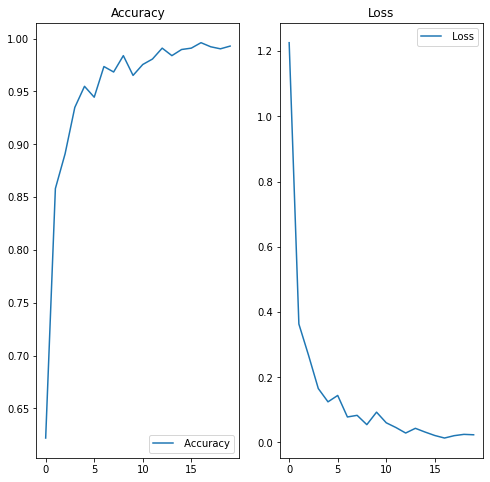

In [23]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label=' Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy')
plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label=' Loss')
plt.legend(loc='upper right')
plt.title('Loss')
plt.show()

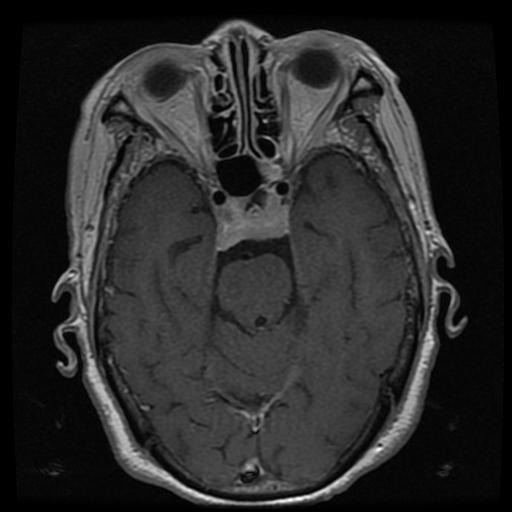

In [29]:
image_path = "/gdrive/My Drive/tumor.jpg"
image = preprocessing.image.load_img(image_path)
image_array = preprocessing.image.img_to_array(image)
scaled_img = np.expand_dims(image_array, axis=0)
image

In [30]:
pred = model.predict(scaled_img)

In [31]:
output = class_names[np.argmax(pred)]

In [35]:
output

'pituitary_brain_tumor'

In [36]:
model.save("Disease_Detection.h5")